# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.discrete.discrete_model import Logit
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
%matplotlib inline

import seaborn as sns



/Users/nondracek/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

5. We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
np.random.seed(9001)
df = pd.read_csv('dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
# split data into X and y
y = data_train['Cancer_type']
X = data_train[data_train.columns[data_train.columns != 'Cancer_type']]
y_test = data_test['Cancer_type']
X_test = data_test[data_train.columns[data_train.columns != 'Cancer_type']]

# Normalize X's
X_test = (X_test - X.mean()) / (X.std())
X = (X - X.mean()) / (X.std())

# rebuild full data set with normalized values
data_train = pd.DataFrame(y).join(X)
data_test = pd.DataFrame(y_test).join(X_test)

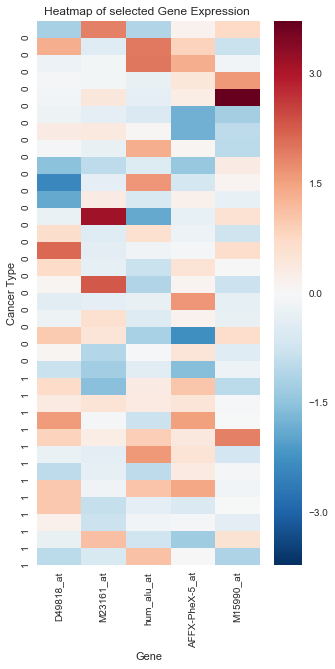

In [4]:
plt.figure(figsize=  (5,10))
sns.heatmap(data_train.sort_values('Cancer_type')[['D49818_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at', 'M15990_at']])
plt.yticks(range(len(data_train)),np.append(data_train['Cancer_type'][data_train['Cancer_type'] == 1].values, data_train['Cancer_type'][data_train['Cancer_type'] == 0].values))
plt.ylabel('Cancer Type')
plt.xlabel('Gene')
plt.title('Heatmap of selected Gene Expression ')
plt.show()

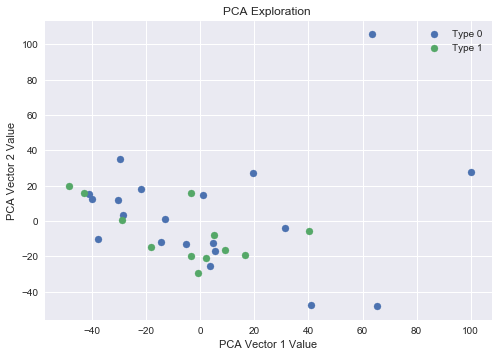

In [5]:
# Create PCA components
pca = PCA(n_components = 2)
X_PCA = pca.fit_transform(X, y)
# plot them
plt.scatter(X_PCA[data_train['Cancer_type'] == 0][:,0], X_PCA[data_train['Cancer_type'] == 0][:,1], label = 'Type 0')
plt.scatter(X_PCA[data_train['Cancer_type'] == 1][:,0], X_PCA[data_train['Cancer_type'] == 1][:,1], label = 'Type 1')
plt.ylabel('PCA Vector 2 Value')
plt.xlabel('PCA Vector 1 Value')
plt.title('PCA Exploration ')
plt.legend()
plt.show()

### Analysis

#### Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

Yes, when there are more predictors than there are observations, regression models like linear regression do not have a unique solution. This can potentially be resolved by PCA

#### By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

There are no incredibly clear distinction in the heatmap for any of these genes. It looks like  `M15990_at` and `D49818_at` show some difference that could be useful in discriminating between the two classes. 

#### How well do the top two principal components discriminate between the two classes?

Not particularly well. It is hard to see any noticable difference in the Type0 and Type1 classes. It seems that the Type 0 classes have a much larger spread and variability, but not much else seems particulary different between the classes. 

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `M23161_at`.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').

4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



In [6]:
x = sm.add_constant(X['D29963_at'])
X_new = sm.add_constant(X)
model = OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Cancer_type   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.346
Date:                Wed, 18 Oct 2017   Prob (F-statistic):             0.0773
Time:                        13:45:25   Log-Likelihood:                -20.501
No. Observations:                  32   AIC:                             45.00
Df Residuals:                      30   BIC:                             47.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3750      0.084      4.473      0.000       0.204       0.546
D29963_at      0.1558      0.085      1.829      0.077      -0.018       0.330
==============================================================================
Omnibus:                       14.047   Durbin-Watson:                   0.443
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                3.932
Skew:                           0.498   Prob(JB):                        0.140
Kurtosis:                       1.601   Cond. No.                         1.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# function for calculating accuracy of classification
def accuracy (y, predict):
    return 1 - np.sum((predict < .5) != (y == 0))/len(y)

In [8]:
train_accuracy = accuracy(y, model.predict())
train_accuracy

0.71875

In [9]:
test_preds = (model.predict(sm.add_constant(X_test['D29963_at'])))
test_accuracy = accuracy(y_test, test_preds)
test_accuracy

0.82926829268292679

In [10]:
log_model = Logit(y, x).fit()
log_model.summary()

Optimization terminated successfully.
         Current function value: 0.609594
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Cancer_type   No. Observations:                   32
Model:                          Logit   Df Residuals:                       30
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Oct 2017   Pseudo R-squ.:                 0.07856
Time:                        13:45:25   Log-Likelihood:                -19.507
converged:                       True   LL-Null:                       -21.170
                                        LLR p-value:                   0.06819
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5445      0.386     -1.411      0.158      -1.301       0.212
D29963_at      0.7375      0.451      1.634      0.102      -0.147       1.622
==============================================================================
"""

In [11]:
train_accuracy = accuracy(y, log_model.predict())
train_accuracy

0.71875

In [12]:
test_preds = (log_model.predict(sm.add_constant(X_test['D29963_at'])))
test_accuracy = accuracy(y_test, test_preds)
test_accuracy

0.82926829268292679

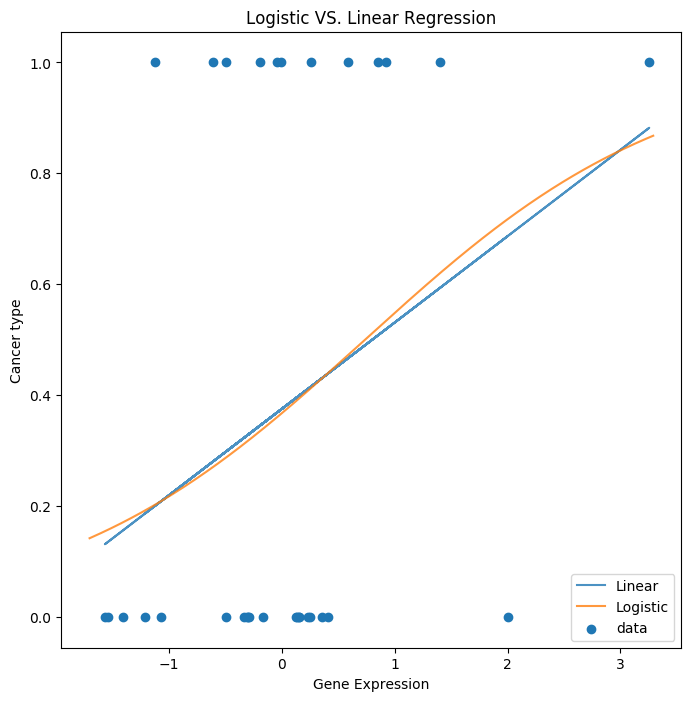

In [13]:
sns.reset_defaults()
plt.figure(figsize=(8,8))
# Create Scatter plot of data
plt.scatter(X['D29963_at'], y, label = 'data')
# Plot linear regression
plt.plot(X['D29963_at'], model.predict(), alpha = .8, label = 'Linear')
# Create x intervals for logistic regression line to look smooth
x_ticks = np.arange(-1.7,3.3,.01)
x_ticks_model = sm.add_constant(x_ticks)
# sort x and y values for plotting
plot_values= list(zip(x_ticks, log_model.predict(x_ticks_model)))
plot_values.sort()
# split x and y from sorted list
plot_x = []
plot_y = []
for i,j in plot_values: 
    plot_x.append(i)
    plot_y.append(j)
# plot logisitc regression line
plt.plot(plot_x,plot_y, alpha = .8, label = 'Logistic')
plt.title('Logistic VS. Linear Regression')
plt.xlabel('Gene Expression')
plt.ylabel('Cancer type')
plt.legend()
plt.show()

#### We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

It' hard to predict catagorically from a linear regression for a few regions. First, the lienar regression will continue beyond 0 and 1, which is porblematic as probability must be between 0 and 1. There is also a similar issue to the football data we looked at in lecture where even the successful plays (or 'ALL' cancer in this case) are never a probability of 1 or close to one, so we need to find a benchmark of the probability that actually denotes the cancer.


#### How does the training and test calssification accuracy of this model compare with the linear regression model?  

On both the training and test set it performs identically. 

#### Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

The logistic model looks like it might be slightly better, but there is very little variability between the logisitc and linear model. 

## Part (c): Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

2. "Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

In [14]:
log = LogisticRegression(C = 1000)
log.fit(X, y)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
print('Training Set Accuracy = %f' % accuracy(y, log.predict(X)))

Training Set Accuracy = 1.000000


In [16]:
print('Test Set Accuracy = %f' % accuracy(y_test, log.predict(X_test)))

Test Set Accuracy = 0.975610


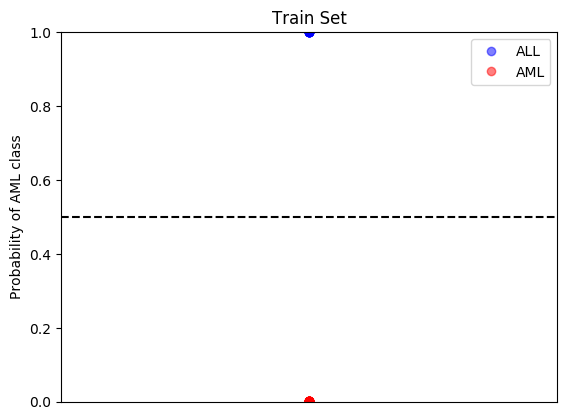

In [17]:
-

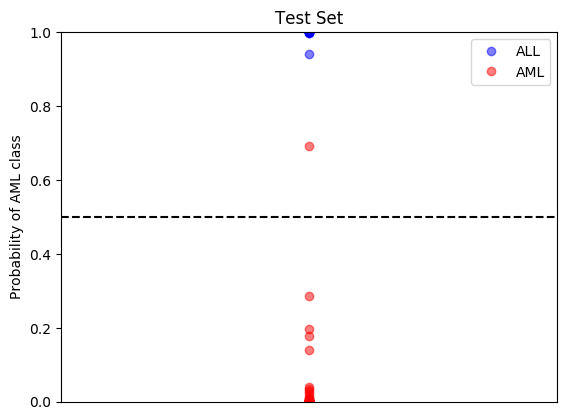

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('Test Set')
visualize_prob(log, X_test, y_test,ax1 )

#### How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

They perform much better, with both train and test almost perfect. 

#### Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

There is a large difference in spread. The training set has very little spread with all of the probabilities at 0 or 1, with the test set instead showing a spread of different numbers in that range. For the test set, there are two points near the .5 line, and one of those points is misclassified. Of the two points though, neither are that close to .5, being away by atleast .2. 

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



In [19]:
bootstrap_data = []
# run 100 bootstrap samples
for i in range(100):
    # randomly select 32 data points from training data with replacement
    index = np.random.randint(0,32,32)
    X_bootstrap = X.iloc[index]
    y_bootstrap = y.iloc[index]
    # run logistic regression and store coefficients
    log = LogisticRegression(C = 1000)
    log.fit(X_bootstrap, y_bootstrap)
    bootstrap_data.append(log.coef_[0])

In [20]:
# Get .025 and .975 quantiles of bootstrap data for each coefficient
bootstrap_data = pd.DataFrame(data=np.array(bootstrap_data), columns=X.columns)
low = bootstrap_data.quantile(.025).values
high = bootstrap_data.quantile(.975).values
# find all confidence intervals that do not include 0
significant = [not(low[i] <= 0 and high[i] >= 0) for i in range(bootstrap_data.shape[1])]
print('Number of significant coefficients at 95%% level = %i'%np.sum(significant))

Number of significant coefficients at 95% level = 1357


## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


In [21]:
Var90 = False
i = 0

# Run PCA with increasing number of components until 90% variance
while not Var90:
    i += 1
    pca = PCA(n_components = i)
    pca.fit(X, y)
    if np.sum(pca.explained_variance_ratio_) >= .9:
        Var90 = True

i

24

In [22]:
# Fit the pca model to the train and test data
X_PCA = pca.transform(X)
X_PCA_Test = pca.transform(X_test)

# Fit a logistic model with PCA predictors
log = LogisticRegression(C = 10000)
log.fit(X_PCA, y)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
print('Training Set Accuracy = %f' % accuracy(y, log.predict(X_PCA)))

Training Set Accuracy = 1.000000


In [24]:
print('Test Set Accuracy = %f' % accuracy(y_test, log.predict(X_PCA_Test)))

Test Set Accuracy = 0.926829


In [25]:
# KFold with 5 splits
kf = KFold(n_splits=5)
best_pca = []
for train_index, test_index in kf.split(data_train):
    train_set = data_train.iloc[train_index]
    test_set = data_train.iloc[test_index]
    yK = train_set['Cancer_type']
    yK_test = test_set['Cancer_type']
    xK = list(train_set.columns)
    xK.remove('Cancer_type')
    XK = train_set[xK]
    XK_test = test_set[xK]
    acc = [0,0]
    # Test predictors up to a large number (60 in this case) and save the most accurate one
    for i in range(1,60):
        pca = PCA(n_components = i)
        pca.fit(XK, yK)
        X_PCA = pca.transform(XK)
        X_PCA_Test = pca.transform(XK_test)
        log = LogisticRegression(C = 10000)        
        log.fit(X_PCA, yK)
        if acc[0] < accuracy(yK_test, log.predict(X_PCA_Test)):
            acc[0] = accuracy(yK_test, log.predict(X_PCA_Test))
            acc[1] = i
    best_pca.append(acc[1])

np.mean(best_pca)

10.800000000000001

In [26]:
# Round up from the 10.8 we found with KFold to run PCA with 11 components
pca = PCA(n_components = 11)
pca.fit(X, y)
X_PCA = pca.transform(X)
X_PCA_Test = pca.transform(X_test)

# Fit the PCA predictors to log model
log = LogisticRegression(C = 10000)        
log.fit(X_PCA, y)

print('Training Set Accuracy = %f' % accuracy(y, log.predict(X_PCA)))
print('Test Set Accuracy = %f' % accuracy(y_test, log.predict(X_PCA_Test)))

Training Set Accuracy = 1.000000
Test Set Accuracy = 0.926829


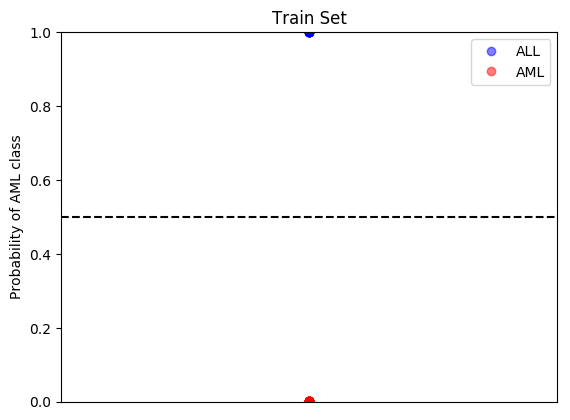

In [27]:
# Plot graphs from part(c) with PCA data
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('Train Set')
visualize_prob(log, X_PCA, y,ax1 )

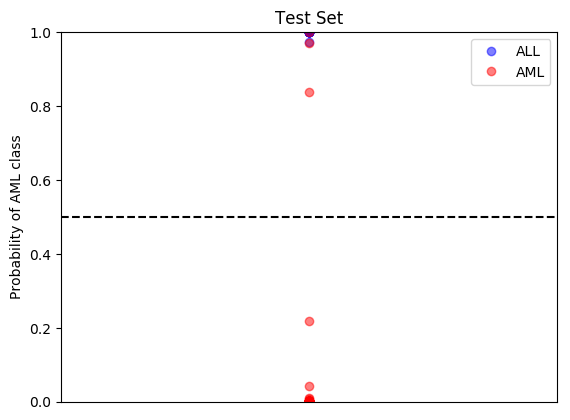

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('Test Set')
visualize_prob(log, X_PCA_Test, y_test,ax1 )

#### How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?

The training set accuracy for all the models was 100%, but the test accuracy was different. The test accuracy for (c) was 0.975610 whereas for this part the test accuracy was 0.926829. So, this shows that using all the preidctors gives a more accuracte model than limiting the predictors using PCA. This makes sense because using all predictors should give us more information to model with; however, there are too many predictors (more than we have data rows), so PCA reduces the number of predictors and keeping predictors responsible for 90% of variance keeps a large number of the important predictors in the combinations in PCA.

#### Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations).

Using kfold, we chose the best number of principla components to be 11 by averaging out the number of comoponents with the highest accuracy for each of the 5 folds. The test performance accuracy for 11 components was 0.926829, the same as running PCA with 90% variance. At first it seems odd that we got the same accuracy as with the previous test, but because the data is catagorical it makes sense that there are a finite number of set accuracies. We thought the accuracy would be higher, but considering that KFolds is splitting up our already small dataset, each group of training data could have high variance.

#### Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)?

Training set is of course 100% again, but the test set is a bit different. Unfortunately, there are more incorrectly classified false possitives, but there is much less variance in the possitive and negative catagories with predictors being either very close to 1 or 0 instead of spread out in a wider range.